## Libraries

In [20]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
import yfinance as yf
import torch

## Dataset Gaz

In [4]:
#Essayer DJI  (Dow Johns)
stock = 'BZ=F'
start = '2007-07-30'
end = '2024-04-01'

dataset = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


## Data cleaning

In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
dataset.shape

(4137, 6)

In [7]:
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387


<AxesSubplot: xlabel='Date'>

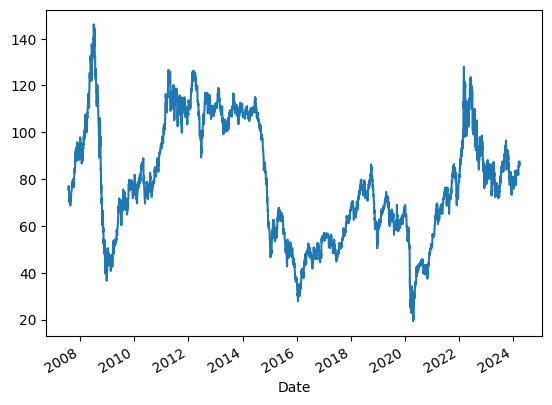

In [8]:
dataset['Close'].plot()

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [10]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513


## Feature engineering

In [11]:
##Ajouter Indicateurs RSI MACD
import numpy as np
import pandas as pd

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

calculate_macd(dataset)
calculate_rsi(dataset)
# Drop NaN values that were introduced by the calculations
dataset.dropna(inplace=True)

dataset.columns


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MACD', 'Signal_Line', 'RSI'], dtype='object')

## Split training & test set 

In [12]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [13]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

## PPO algorithm

In [14]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


In [15]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten

class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        q = self.q(x)
        return q


## Agent

In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.batch_size = batch_size

        # Initialisation des réseaux
        self.actor = ActorNetwork(n_actions)
        self.critic = CriticNetwork()
        self.memory = PPOMemory(batch_size)

        # Compilation des modèles
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        
        # Ajout de l'attribut inventory
        self.inventory = []

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs=probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        return action.numpy()[0], log_prob.numpy()[0], value.numpy()[0]

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()

            values = vals_arr.squeeze()
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr) - 1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr) - 1):
                    a_t += discount * (reward_arr[k] + self.gamma * values[k + 1] * (1 - int(dones_arr[k])) - values[k])
                    discount *= self.gamma * self.gae_lambda
                advantage[t] = a_t
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10)  # Normalize

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch], dtype=tf.float32)
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch], dtype=tf.float32)
                    actions = tf.convert_to_tensor(action_arr[batch], dtype=tf.int32)

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs=probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = tf.squeeze(self.critic(states), 1)
                    prob_ratio = tf.exp(new_probs - old_probs)
                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip) * advantage[batch]
                    actor_loss = -tf.reduce_mean(tf.minimum(weighted_probs, clipped_probs))

                    returns = advantage[batch] + values[batch]
                    critic_loss = keras.losses.MSE(returns, critic_value)

                actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
                critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
                self.actor.optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
                self.critic.optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))
        self.memory.clear_memory()
        

In [17]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

def getStockData(key):
    vec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))  # Only Close column
    return vec

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

import matplotlib.pyplot as plt

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling signal', markevery=states_sell)
    plt.title(f'Total gains: {formatPrice(profit)}')
    plt.legend()
    plt.show()


Episode 0/10
Total Profit: -$238.62


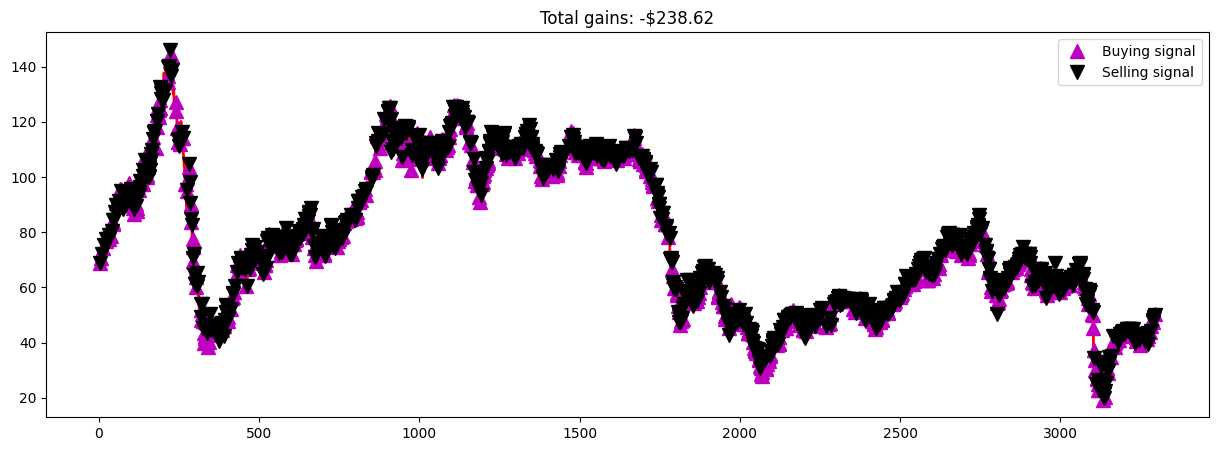

Episode 1/10
Total Profit: -$607.22


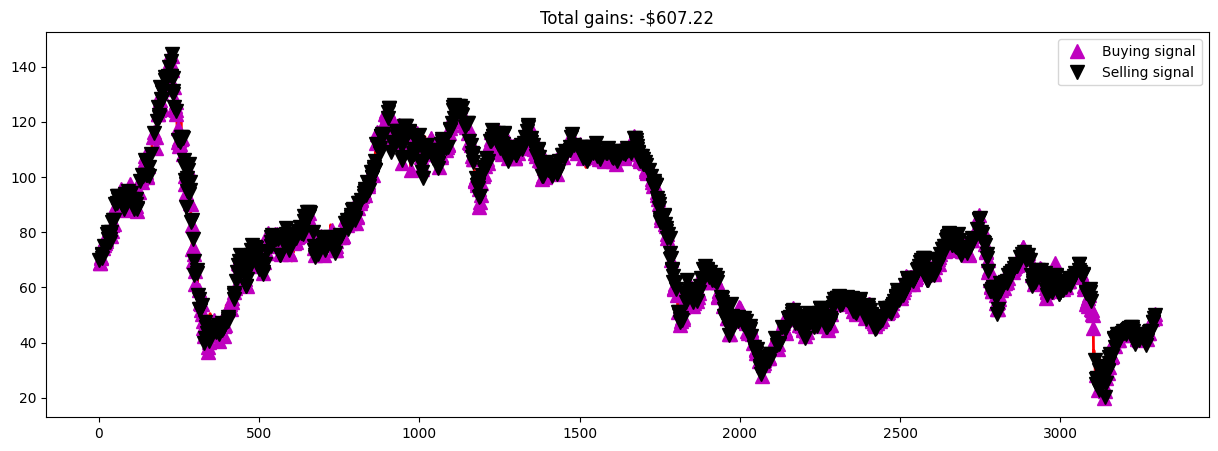

Episode 2/10
Total Profit: $276.42


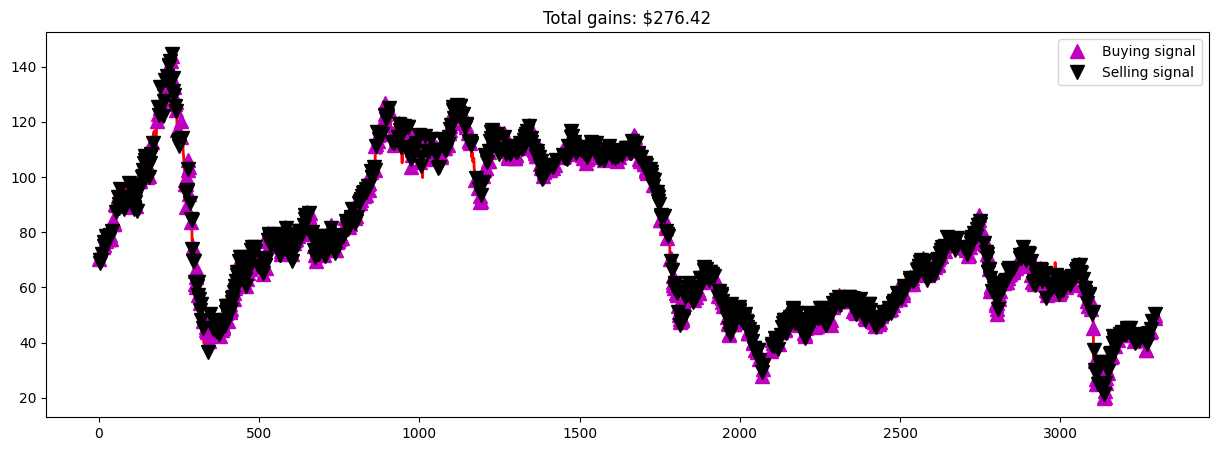

Episode 3/10
Total Profit: -$43.43


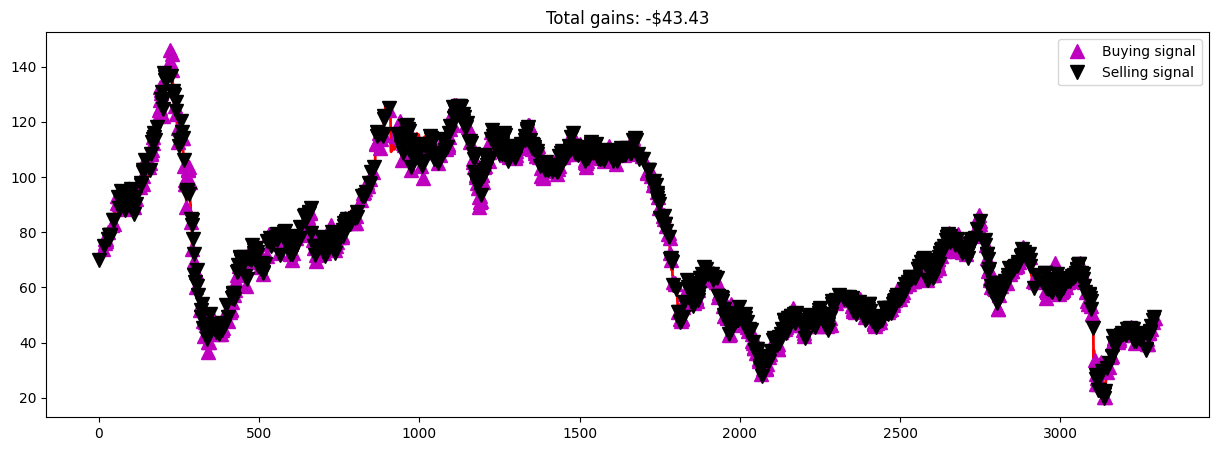

Episode 4/10
Total Profit: $560.11


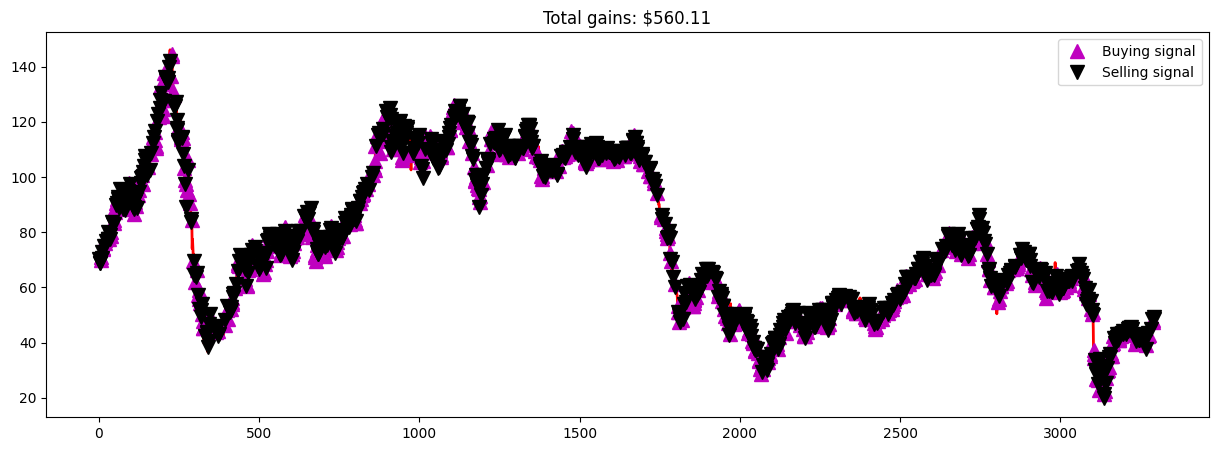

Episode 5/10
Total Profit: -$311.43


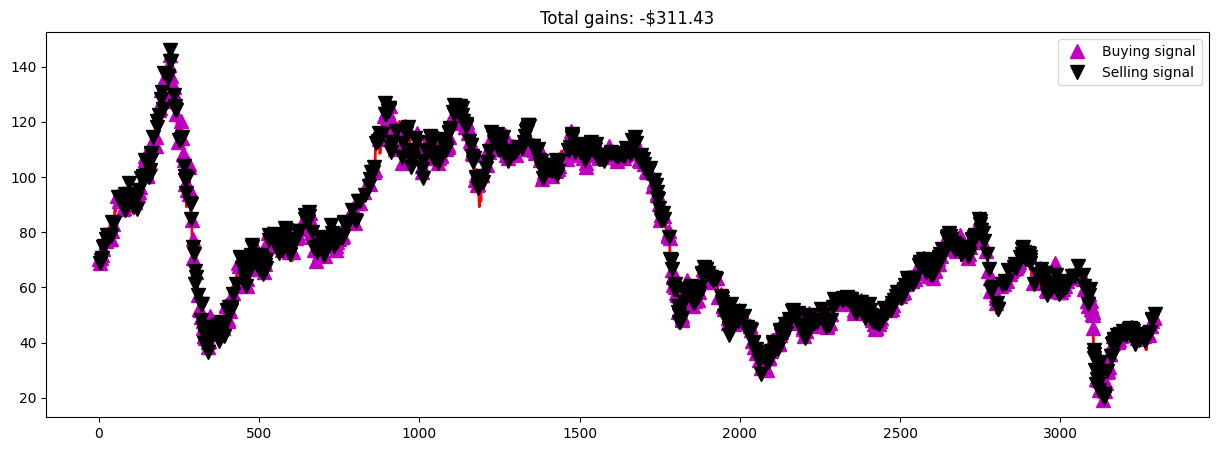

Episode 6/10
Total Profit: $17.14


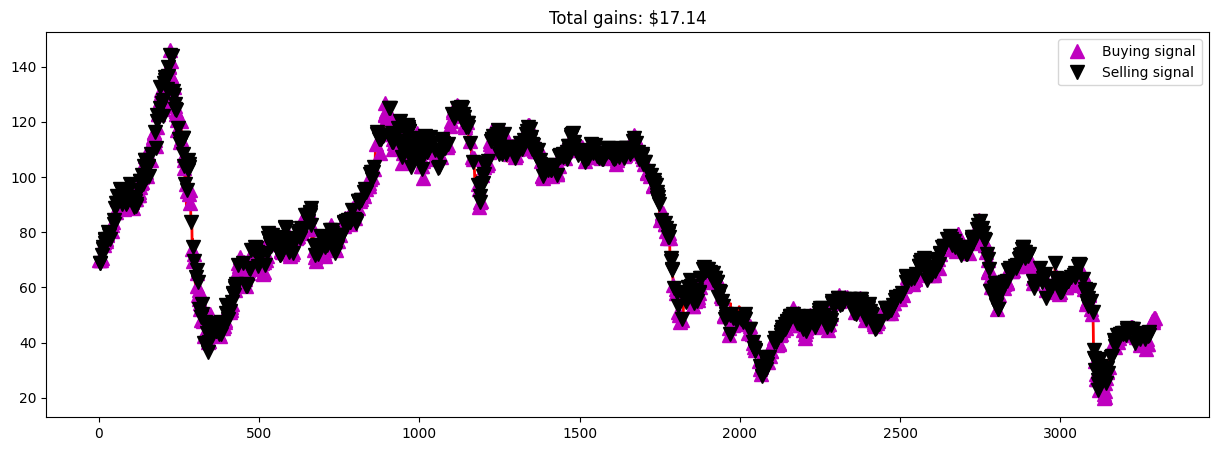

Episode 7/10
Total Profit: $950.09


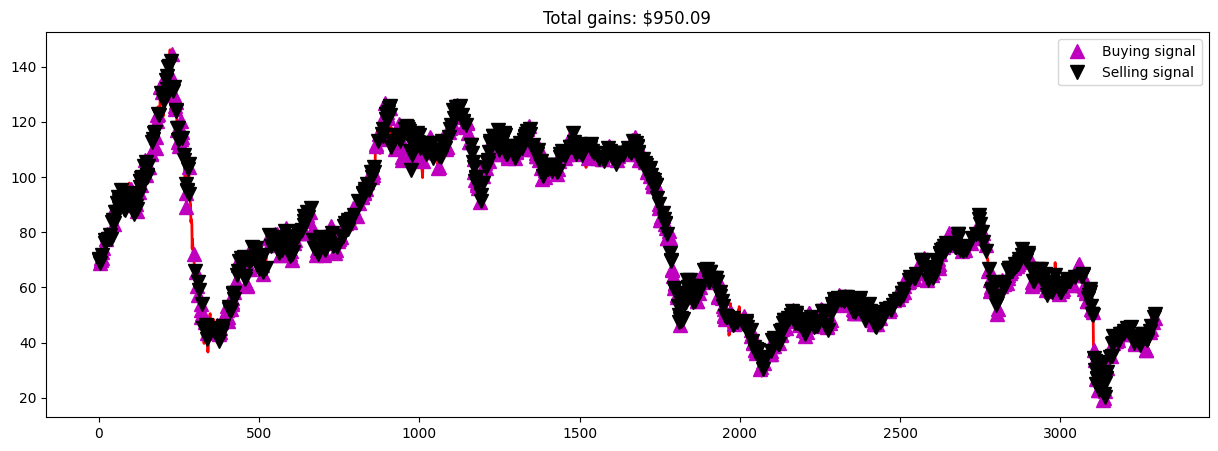

Episode 8/10
Total Profit: -$162.10


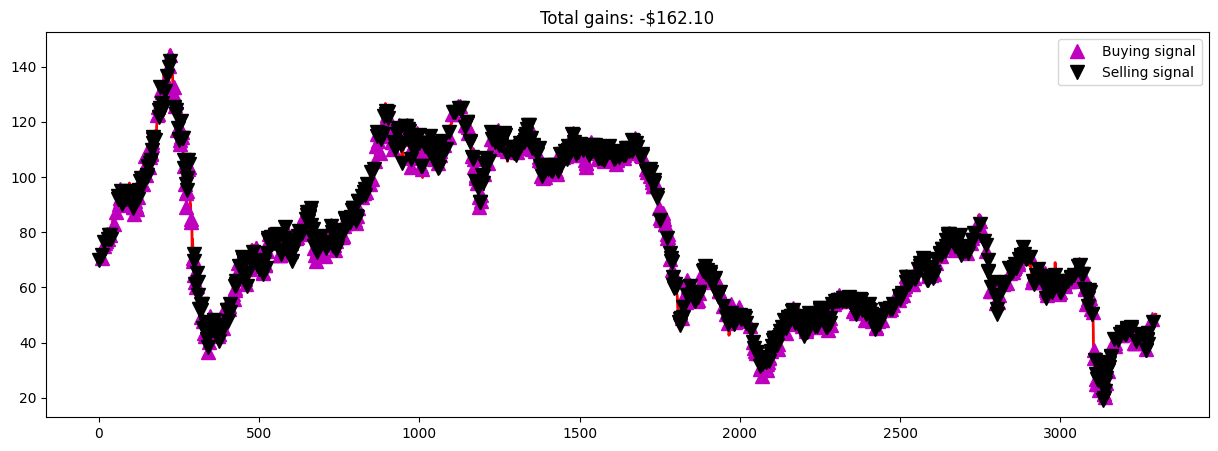

Episode 9/10
Total Profit: -$476.81


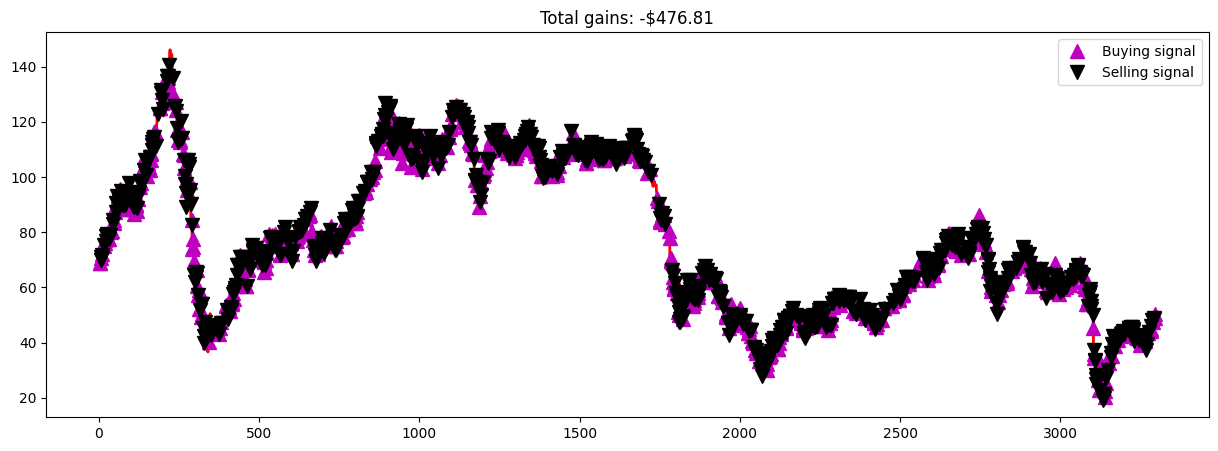

Episode 10/10
Total Profit: $226.93


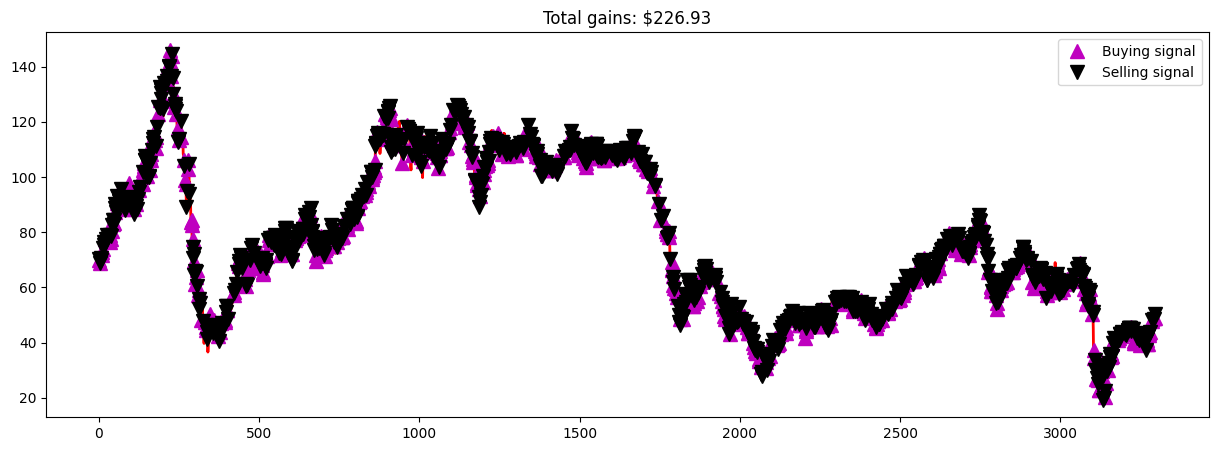

In [18]:
n_actions = 3 
window_size=10 
input_dims = window_size 
agent = Agent(n_actions=n_actions, input_dims=input_dims)
episode_count=10

data = X_train
l = len(data) - 1

for e in range(episode_count + 1):
    print(f"Episode {e}/{episode_count}")
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    states_sell = []
    states_buy = []
    
    for t in range(l):
        action, prob, val = agent.choose_action(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0  # La récompense doit être calculée en fonction de l'action effectuée
        
        if action == 1:  # Supposons que 1 soit l'achat
            agent.inventory.append(data[t])
            states_buy.append(t)
        elif action == 2 and len(agent.inventory) > 0:  # Supposons que 2 soit la vente
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
        
        done = t == l - 1
        
        # Important : stocker la transition d'une manière légèrement différente pour PPO
        agent.store_transition(state, action, prob, val, reward, done)
        
        state = next_state
        
        if done:
            print("Total Profit: " + formatPrice(total_profit))
            plot_behavior(data, states_buy, states_sell, total_profit)
    
    # Après avoir collecté suffisamment de données, entraîner l'agent PPO
    agent.learn()


In [112]:
print("Actor Model Summary:")
print(agent.actor.summary())
print("\nCritic Model Summary:")
print(agent.critic.summary())

Actor Model Summary:
Model: "actor_network_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            multiple                  3584      
                                                                 
 dense_97 (Dense)            multiple                  65792     
                                                                 
 dense_98 (Dense)            multiple                  771       
                                                                 
Total params: 70147 (274.01 KB)
Trainable params: 70147 (274.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Critic Model Summary:
Model: "critic_network_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            multiple                  3584      
  

Episode 0/10
Total Profit: -$80.38


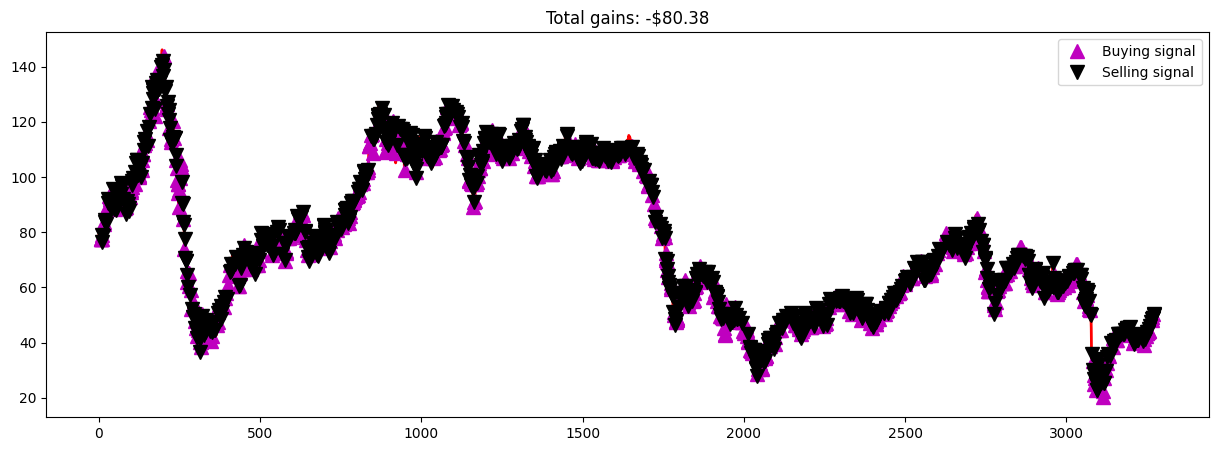

Episode 1/10
Total Profit: -$800.30


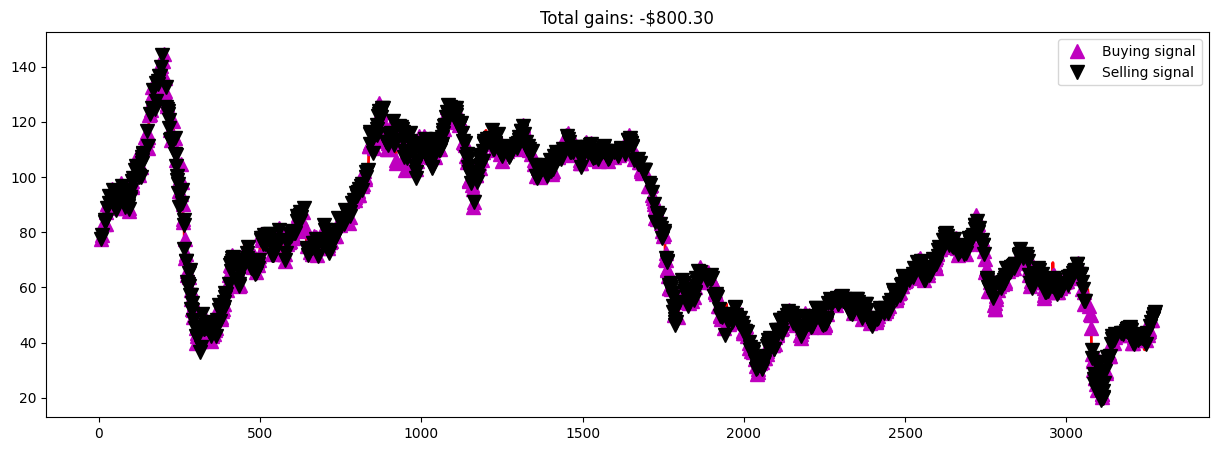

Episode 2/10


KeyboardInterrupt: 

In [128]:
n_actions = 3 
window_size = 10 
input_dims = window_size 
agent = Agent(n_actions=n_actions, input_dims=input_dims)
episode_count = 10

data = X_train
l = len(data) - 1

for e in range(episode_count + 1):
    print(f"Episode {e}/{episode_count}")
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    states_sell = []
    states_buy = []
    
    for t in range(l):
        action, prob, val = agent.choose_action(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0  # Reward should be calculated based on the action taken
        
        if action == 1:  # Suppose 1 represents buying
            agent.inventory.append(data[t])
            states_buy.append(t)
        elif action == 2 and len(agent.inventory) > 0:  # Suppose 2 represents selling
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
        
        done = t == l - 1
        
        # Store the transition in a slightly different manner for PPO
        agent.store_transition(state, action, prob, val, reward, done)
        
        state = next_state
        
        if done:
            print("Total Profit: " + formatPrice(total_profit))
            plot_behavior(data, states_buy, states_sell, total_profit)
    
    # After collecting enough data, train the PPO agent
    agent.learn()

In [132]:
# Assumer que `agent` est déjà défini et formé correctement ci-dessus.

test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
states_sell_test = []
states_buy_test = []

# Pas besoin de charger le modèle; supposer que `agent` est déjà le modèle formé.

for t in range(l_test):
    action, _, _ = agent.choose_action(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:  # Supposons que 1 correspond à l'action d'achat.
        states_buy_test.append(t)
        if len(agent.inventory) > 0:  # Supposons qu'on ne peut acheter qu'après avoir vendu.
            bought_price = agent.inventory.pop(0)  # Utiliser l'inventaire pour stocker le prix d'achat.
            print(f"Buy: {formatPrice(test_data[t])}")
    elif action == 2 and len(agent.inventory) > 0:  # Supposons que 2 correspond à l'action de vente.
        bought_price = agent.inventory.pop(0)  # Vendre le dernier achat.
        profit = test_data[t] - bought_price
        reward = max(profit, 0)
        total_profit += profit
        states_sell_test.append(t)
        print(f"Sell: {formatPrice(test_data[t])} | Profit: {formatPrice(profit)}")

    # Ici, pas de mécanisme d'apprentissage car nous sommes en phase de test/évaluation.
    state = next_state

    if t == l_test - 1:
        print("------------------------------------------")
        print(f"Total Profit: {formatPrice(total_profit)}")
        print("------------------------------------------")

# Visualisation des actions d'achat et de vente sur les données de test.
plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)


IndexError: list index out of range